<a href="https://colab.research.google.com/github/trevinofernando/Algorithms-for-Machine-Learning/blob/master/SupportVectorMachine%26NaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

#Glass Dataset

In [30]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"

###Features

The features in the Glass dataset are: Refractive_index and the levels of Sodium, Magnesium, Aluminum, Silicon, Potassium, Calcium, Barium and Iron as a weight percent.

In [31]:
header = ['Id', 'Refractive_index', 'Sodium', 'Magnesium', 'Aluminum', 'Silicon', 'Potassium', 'Calcium', 'Barium', 'Iron', 'class']

###Classes

The classes in the Glass dataset include: building windows float processed and non float processed, vehicle windows float processed and non float processed, containers, tableware and headlamps.

In [32]:
classes = ['', 'building_windows_float_processed', 'building_windows_non_float_processed', 'vehicle_windows_float_processed', 'vehicle_windows_non_float_processed', 'containers', 'tableware', 'headlamps']

###Data Exploration

In [33]:
dataframe = pd.read_csv(url, names = header)

 #remove Id column which won't be used
header.remove('Id')
dataframe = dataframe.drop('Id', axis=1)

display(HTML(dataframe.describe().to_html()))
print("======================================================================================================")
dataframe

,Refractive_index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron,class
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


,Refractive_index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron,class
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


###Class Prior

We can see that the data isn't balanced beacuase more than 65% of the entries are classified with only 2 labels: 1 and 2 (building_windows_float_processed and building_windows_non_float_processed). No entry is classified with class 4 (vehicle_windows_non_float_processed) and the other 4 classes only represent about 30% of the data.

In [34]:
#Get priors
priors = dataframe['class'].value_counts(sort=False, normalize=True)

#initialize a series filled with 0's for all classes
empty_priors = pd.Series([0.000000 for i in range(len(classes)-1)], index=range(1,len(classes)))

#add both series to add the missing classes (class 4)
priors = priors.add(empty_priors, fill_value=0)
print(priors)

1    0.327103
2    0.355140
3    0.079439
4    0.000000
5    0.060748
6    0.042056
7    0.135514
dtype: float64


###Entropy of the class prior distribution

entropy = -sum(prior * log(prior))

In [35]:
from scipy.stats import entropy
entropy(priors, base = 2)

2.1765339923982006

###Mean and Standard Deviation of each class

In [36]:
df_by_class = dataframe.groupby(['class'])
print("Mean:")
#dataframe.describe().loc[['mean']].iloc[:, 0:-1]
means = df_by_class.mean()
display(means)
print("\n\nStandard Deviation:")
stds = df_by_class.std()
display(HTML(stds.to_html()))


Mean:


,Refractive_index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron
class,,,,,,,,,
1,1.518718,13.242286,3.552429,1.163857,72.619143,0.447429,8.797286,0.012714,0.057000
2,1.518619,13.111711,3.002105,1.408158,72.598026,0.521053,9.073684,0.050263,0.079737
3,1.517964,13.437059,3.543529,1.201176,72.404706,0.406471,8.782941,0.008824,0.057059
5,1.518928,12.827692,0.773846,2.033846,72.366154,1.470000,10.123846,0.187692,0.060769
6,1.517456,14.646667,1.305556,1.366667,73.206667,0.000000,9.356667,0.000000,0.000000
7,1.517116,14.442069,0.538276,2.122759,72.965862,0.325172,8.491379,1.040000,0.013448




Standard Deviation:


,Refractive_index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron
class,,,,,,,,,
1,0.002268,0.499301,0.247043,0.273158,0.569484,0.214879,0.574807,0.083838,0.089075
2,0.003802,0.664159,1.215661,0.318340,0.724573,0.213726,1.921635,0.362340,0.106433
3,0.001916,0.506887,0.162786,0.347489,0.512276,0.229890,0.380111,0.036380,0.107864
5,0.003345,0.777037,0.999146,0.693920,1.282319,2.138695,2.183791,0.608251,0.155588
6,0.003116,1.084020,1.097134,0.571861,1.079467,0.000000,1.449948,0.000000,0.000000
7,0.002545,0.686359,1.117683,0.442726,0.940234,0.668493,0.973505,0.665341,0.029794


In [37]:
data = np.array([0.000000 for entry in range(len(header))])
emptyEntry = pd.Series(data,index=header)

stats = {}
for i in range(1, len(classes)):
    if not i in means.index:
      stats[classes[i]] = pd.DataFrame({'Mean': emptyEntry, 'Std': emptyEntry})
    else:
      stats[classes[i]] = means.loc[i].to_frame(name = 'Mean')
      stats[classes[i]] = stats[classes[i]].join(stds.loc[i].to_frame(name = 'Std'))

for cl in classes[1:]:
  print('\nMean and Standard deviation for class "{0}" shown below:'.format(cl))
  display(stats[cl])


Mean and Standard deviation for class "building_windows_float_processed" shown below:


,Mean,Std
Refractive_index,1.518718,0.002268
Sodium,13.242286,0.499301
Magnesium,3.552429,0.247043
Aluminum,1.163857,0.273158
Silicon,72.619143,0.569484
Potassium,0.447429,0.214879
Calcium,8.797286,0.574807
Barium,0.012714,0.083838
Iron,0.057000,0.089075



Mean and Standard deviation for class "building_windows_non_float_processed" shown below:


,Mean,Std
Refractive_index,1.518619,0.003802
Sodium,13.111711,0.664159
Magnesium,3.002105,1.215661
Aluminum,1.408158,0.318340
Silicon,72.598026,0.724573
Potassium,0.521053,0.213726
Calcium,9.073684,1.921635
Barium,0.050263,0.362340
Iron,0.079737,0.106433



Mean and Standard deviation for class "vehicle_windows_float_processed" shown below:


,Mean,Std
Refractive_index,1.517964,0.001916
Sodium,13.437059,0.506887
Magnesium,3.543529,0.162786
Aluminum,1.201176,0.347489
Silicon,72.404706,0.512276
Potassium,0.406471,0.229890
Calcium,8.782941,0.380111
Barium,0.008824,0.036380
Iron,0.057059,0.107864



Mean and Standard deviation for class "vehicle_windows_non_float_processed" shown below:


,Mean,Std
Refractive_index,0.0,0.0
Sodium,0.0,0.0
Magnesium,0.0,0.0
Aluminum,0.0,0.0
Silicon,0.0,0.0
Potassium,0.0,0.0
Calcium,0.0,0.0
Barium,0.0,0.0
Iron,0.0,0.0
class,0.0,0.0



Mean and Standard deviation for class "containers" shown below:


,Mean,Std
Refractive_index,1.518928,0.003345
Sodium,12.827692,0.777037
Magnesium,0.773846,0.999146
Aluminum,2.033846,0.693920
Silicon,72.366154,1.282319
Potassium,1.470000,2.138695
Calcium,10.123846,2.183791
Barium,0.187692,0.608251
Iron,0.060769,0.155588



Mean and Standard deviation for class "tableware" shown below:


,Mean,Std
Refractive_index,1.517456,0.003116
Sodium,14.646667,1.084020
Magnesium,1.305556,1.097134
Aluminum,1.366667,0.571861
Silicon,73.206667,1.079467
Potassium,0.000000,0.000000
Calcium,9.356667,1.449948
Barium,0.000000,0.000000
Iron,0.000000,0.000000



Mean and Standard deviation for class "headlamps" shown below:


,Mean,Std
Refractive_index,1.517116,0.002545
Sodium,14.442069,0.686359
Magnesium,0.538276,1.117683
Aluminum,2.122759,0.442726
Silicon,72.965862,0.940234
Potassium,0.325172,0.668493
Calcium,8.491379,0.973505
Barium,1.040000,0.665341
Iron,0.013448,0.029794


###Gaussian Naive Bayes

In [38]:
from sklearn.naive_bayes import GaussianNB

X = dataframe.iloc[:, :-1].values
y = dataframe.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
correct_predictions = (y_test == y_pred).sum()
print("Accuracy = {0} with {1} out of {2} points correctly labeled".format(correct_predictions/X_test.shape[0] * 100.0, correct_predictions, X_test.shape[0]))

Accuracy = 58.139534883720934 with 25 out of 43 points correctly labeled


### Probability Density Function

0.044318484119380115


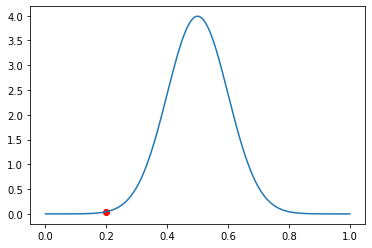

In [39]:
from scipy.stats import norm
x = 0.2
mean = 0.5
std = 0.1

print(norm.pdf(x, mean, std))
plt.plot(x,norm.pdf(x, mean, std),'ro') 

x = np.linspace(0.0, 1, 1000)
plt.plot(x, norm.pdf(x, mean, std))
plt.show()

Class 1: 
The posterior probability of Class 1 = 0.6 * 0.044318484119380115 * 0.3989422804014327 = 0.01060831027111211


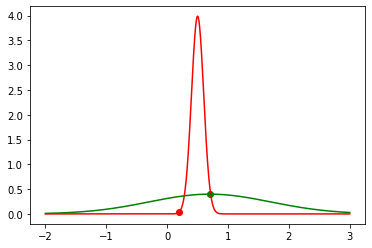

Class 2: 
The posterior probability of Class 2 = 0.4 * 3.989422804014327 * 0.2699548325659404 = 0.4307855860369728


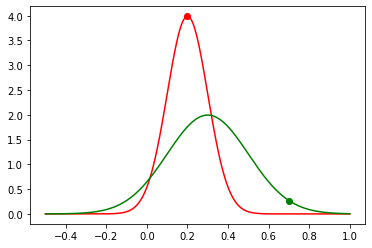

Because 0.4307855860369728 > 0.01060831027111211. Class 2 is a better option


In [40]:
height = 0.2
width = 0.7
pdf_height= 0.0
pdf_width= 0.0

print("Class 1: ")
prior = 0.6
pdf_height = norm.pdf(height, 0.5, 0.1)
pdf_width= norm.pdf(width, 0.7, 1)
post_prob_class1 = prior*pdf_height*pdf_width
print("The posterior probability of Class 1 = {0} * {1} * {2} = {3}".format(prior, pdf_height, pdf_width, post_prob_class1))

x = np.linspace(-2.0, 3.0, 1000)
plt.plot(height, pdf_height,'ro') 
plt.plot(width, pdf_width, 'go')
plt.plot(x, norm.pdf(x, 0.5, 0.1),'r')
plt.plot(x, norm.pdf(x, 0.7, 1), 'g')
plt.show()


print("Class 2: ")
prior = 0.4
pdf_height = norm.pdf(height, 0.2, 0.1)
pdf_width= norm.pdf(width, 0.3, 0.2)
post_prob_class2 = prior*pdf_height*pdf_width
print("The posterior probability of Class 2 = {0} * {1} * {2} = {3}".format(prior, pdf_height, pdf_width, post_prob_class2))

x = np.linspace(-0.5, 1.0, 1000)
plt.plot(height, pdf_height,'ro') 
plt.plot(width, pdf_width, 'go')
plt.plot(x, norm.pdf(x, 0.2, 0.1),'r')
plt.plot(x, norm.pdf(x, 0.3, 0.2), 'g')
plt.show()

print("Because {0} > {1}. Class 2 is a better option".format(post_prob_class2, post_prob_class1))

###Naive Bayes Classifier for Glass dataset

In [41]:
def Glass_NaiveBayes_Predict(y):
  meanIndex = 0
  stdIndex = 1
  highest_pdf = 0 

  for cl in classes[1:]: #skip first empty entry
    pdf = priors[classes.index(cl)] #initialize
    for i in range(len(header[:-1])): #ignore last entry 'class'
      pdf = pdf * norm.pdf(y[i], stats[cl].iloc[i, meanIndex], max(0.000001, stats[cl].iloc[i, stdIndex]))
    #End For
    if pdf > highest_pdf:
      highest_pdf = pdf
      prediction = cl
    #End If
  #End For
  return prediction
#End Def


new_data = [1.51, 14.64, 1.30, 1.36, 73.20, 0.0, 9.35, 0.0, 0.0] #should be tableware
prediction = Glass_NaiveBayes_Predict(new_data)

print("Prediction: '{}'\nBelow is shown the table with the 'new_data' coloumn next to it for reference".format(prediction))
stats[prediction].join(pd.DataFrame({'new_data': pd.Series(new_data,index=header[:-1])}))

Prediction: 'tableware'
Below is shown the table with the 'new_data' coloumn next to it for reference


,Mean,Std,new_data
Refractive_index,1.517456,0.003116,1.51
Sodium,14.646667,1.084020,14.64
Magnesium,1.305556,1.097134,1.30
Aluminum,1.366667,0.571861,1.36
Silicon,73.206667,1.079467,73.20
Potassium,0.000000,0.000000,0.00
Calcium,9.356667,1.449948,9.35
Barium,0.000000,0.000000,0.00
Iron,0.000000,0.000000,0.00


###Support Vector Machine

In [42]:
from sklearn.svm import SVC #https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
X = dataframe.drop('class',1).to_numpy()
y = dataframe['class'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8290)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
SVC().fit(x_train, y_train).predict(x_test)
print("Accuarcy of plain SVC on glass dataset: ", np.count_nonzero(SVC().fit(x_train, y_train).predict(x_test) == y_test)/(len(y_test)))

(171, 9) (43, 9) (171,) (43,)
Accuarcy of plain SVC on glass dataset:  0.2558139534883721


In [43]:

c = 5 #C is for how heavily the misclassification  will be penalized
linear_index = 0
radial_index = 1
clf = [None] * 2
predictions = [None] * 2
accuracies = [None] * 2

clf[linear_index] = SVC(kernel = 'linear', C = c, gamma='auto')
clf[radial_index] = SVC(kernel = 'rbf', C = c,  gamma='auto')

clf[linear_index].fit(x_train, y_train)
clf[radial_index].fit(x_train, y_train)

predictions[linear_index] = clf[linear_index].predict(x_test)
predictions[radial_index] = clf[radial_index].predict(x_test)

accuracies[linear_index] = np.count_nonzero(predictions[linear_index] == y_test)/(len(y_test))
accuracies[radial_index] = np.count_nonzero(predictions[radial_index] == y_test)/(len(y_test))

print("Comapreing both accuarcies:")
print("Linear kernel: {} %".format(accuracies[linear_index] * 100.0))
print("Radial kernel: {} %".format(accuracies[radial_index] * 100.0))
print("The radial kernel achieved a higher accuarcy.")

Comapreing both accuarcies:
Linear kernel: 65.11627906976744 %
Radial kernel: 76.74418604651163 %
The radial kernel achieved a higher accuarcy.


###Confusion Matrix

['building_windows_float_processed', 'building_windows_non_float_processed', 'vehicle_windows_float_processed', 'vehicle_windows_non_float_processed', 'tableware', 'headlamps']


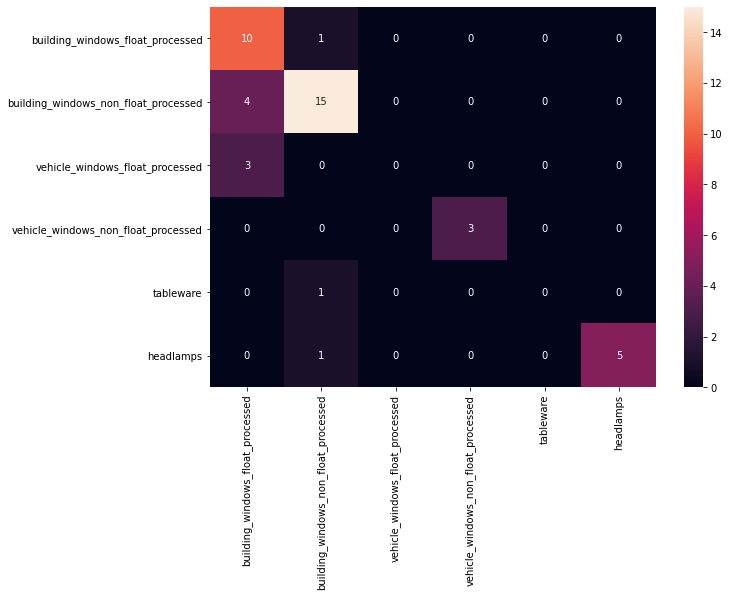

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

conf_matrix = confusion_matrix(y_test, predictions[radial_index])

clean_classes = [x for i,x in enumerate(classes[1:]) if i!=4] #get all items except index 1 and 4
print(clean_classes)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in clean_classes], columns = [i for i in clean_classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

###Best Performing Hyperparameters 

The best accuarcy found used a C = [4, 5, 7, 10],
with an accuarcy = 0.7674418604651163


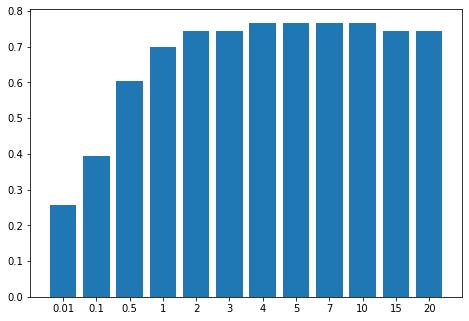

In [45]:
#from sklearn.grid_search import ParameterGrid
import seaborn as sns
Cs = [0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20]
accuracies = [] 
highest_accuracy = 0
highest_accuracy_index = 0

for i in range(len(Cs)):
  clf = SVC(kernel = 'rbf', C = Cs[i], gamma='auto')
  clf.fit(x_train, y_train)
  predictions = clf.predict(x_test)
  accuracies.append(np.count_nonzero(predictions == y_test)/(len(y_test)))
  if accuracies[i] > highest_accuracy:
    highest_accuracy = accuracies[i]
    highest_accuracy_index = i
    clf_with_highest_accuracy = clf
  #End If
#End For

Cs_with_highest_accuracy = [Cs[i] for i, x in enumerate(accuracies) if x == highest_accuracy]
print("The best accuarcy found used a C = {},\nwith an accuarcy = {}".format(Cs_with_highest_accuracy,highest_accuracy))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Cs = ['0.01', '0.1', '0.5', '1',' 2', '3', '4', '5', '7', '10', '15', '20']
ax.bar(Cs,accuracies)
plt.show()

###Suport Vectors

In [46]:
# get support vectors
clf_with_highest_accuracy.support_vectors_

array([[1.51720e+00, 1.33800e+01, 3.50000e+00, ..., 8.43000e+00,
        0.00000e+00, 0.00000e+00],
       [1.51775e+00, 1.28500e+01, 3.48000e+00, ..., 8.56000e+00,
        9.00000e-02, 2.20000e-01],
       [1.51736e+00, 1.27800e+01, 3.62000e+00, ..., 8.70000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.51508e+00, 1.51500e+01, 0.00000e+00, ..., 8.34000e+00,
        6.30000e-01, 0.00000e+00],
       [1.51556e+00, 1.38700e+01, 0.00000e+00, ..., 9.41000e+00,
        8.10000e-01, 1.00000e-02],
       [1.52315e+00, 1.34400e+01, 3.34000e+00, ..., 8.83000e+00,
        0.00000e+00, 0.00000e+00]])

###Performance Improvements to the SVM

1. Rescale data: rescaling the data is supposed to even out the features such that they all have the same weight or level of importance while classifying. But in this case the classifier performed worst with rescaled data, probably becuase not all features are relevant in some clasificatinos and the ones that are important lost relevance after the rescaleing.
2. Using "GridSearchCV" to do search of different parameters for the best results. The search will explore 3 different kernels, many values for C and 2 gamma options. This method did improve the performance of the algorithm.

In [47]:
from sklearn.model_selection import GridSearchCV

def rescale_data(data_):
  rescaled_data = np.divide(np.subtract(data_, min([i for i, x in enumerate(data_.T)])), max([i for i, x in enumerate(data_.T)]) - min([i for i, x in enumerate(data_.T)]))
  return rescaled_data

x_train, x_test, y_train, y_test = train_test_split(rescale_data(X), y, test_size=0.2, random_state=8290)

parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'C':[1, 100], 'gamma':('scale', 'auto') }
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
accuracy = np.count_nonzero(predictions == y_test)/(len(y_test))

print("The best accuarcy found was: {}".format(accuracy))

The best accuarcy found was: 0.6511627906976745
